In [1]:
# Generales
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pydot as pyd
import time
import joblib

# image preprocessing
import os
import sys
import shutil
import glob
import matplotlib.image as mpimg
from PIL import Image

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#keras
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils.vis_utils import plot_model

# tensorflow
import tensorflow as tf
from tensorflow.random import set_seed

#cv2
import cv2
from google.colab.patches import cv2_imshow

In [3]:
%env name=samples1_512_equiv
!echo $name

env: name=samples1_512_equiv
samples1_512_equiv


In [5]:
set_seed(42)
np.random.seed(42)

In [6]:
# Constants

# dirs
inp_img_dir = "./samples/"
out_dir = ""

# init
start_num = 1

height, width = 32, 32

# placeholder
r = "rule_"

# all file names and classes
files = {'1':[], '2':[], '3':[], '4':[]}

# Classes
class1 = [0, 255,
        8, 64, 239, 253,
        32, 251,
        40, 96, 235, 249,
        128, 254,
        136, 192, 238, 252,
        160, 250,
        168, 224, 234, 248]

class2 = [1, 127,
        2, 16, 191, 247,
        3, 17, 63, 119,
        4, 223,
        5, 95,
        6, 20, 159, 215,
        7, 21, 31, 87,
        9, 65, 111, 125,
        10, 80, 175, 245,
        11, 47, 81, 117,
        12, 68, 207, 221,
        13, 69, 79, 93,
        14, 84, 143, 213,
        15, 85,
        19, 55,
        23,
        24, 66, 189, 231,
        25, 61, 67, 103,
        26, 82, 167, 181,
        27, 39, 53, 83,
        28, 70, 157, 199,
        29, 71,
        33, 123,
        34, 48, 187, 243,
        35, 49, 59, 115,
        36, 219,
        37, 91,
        38, 52, 155, 211,
        42, 112, 171, 241,
        43, 113,
        44, 100, 203, 217,
        46, 116, 139, 209,
        50, 179,
        51,
        56, 98, 185, 227,
        57, 99,
        58, 114, 163, 177,
        62, 118, 131, 145,
        72, 237,
        73, 109,
        74, 88, 173, 229,
        76, 205,
        77,
        78, 92, 141, 197,
        94, 133,
        104, 233,
        108, 201,
        130, 144, 190, 246,
        132, 222,
        134, 148, 158, 214,
        138, 174, 208, 224,
        140, 196, 206, 220,
        142, 212,
        152, 188, 194, 230,
        154, 166, 180, 210,
        156, 198,
        162, 176, 186, 242,
        164, 218,
        170, 240,
        172, 202, 216, 228,
        178,
        184, 226,
        200, 236,
        204,
        232]
class3 = [18, 183,
        22, 151,
        30, 86, 135, 149,
        45, 75, 89, 101,
        60, 102, 153, 195,
        90, 165,
        105,
        122, 161,
        126, 129,
        146, 182,
        150]
class4 = [41, 97, 107, 121,
        54, 147,
        106, 120, 169, 225,
        110, 124, 137, 193]

## Dataset Organization



In [7]:
def getPics(classRules, samplesDir):
    classImgs = []

    for r in classRules:
        imgsDir = samplesDir + f'rule_{str(r)}/' 
        classImgs += [imgsDir + f for f in os.listdir(imgsDir)]
    return classImgs


c1_img_list = getPics(class1, inp_img_dir)
c2_img_list = getPics(class2, inp_img_dir)
c3_img_list = getPics(class3, inp_img_dir)
c4_img_list = getPics(class4, inp_img_dir)

## Data Prep

In [8]:
len(c1_img_list), len(c2_img_list), len(c3_img_list), len(c4_img_list)

(49388, 51199, 46576, 46573)

In [9]:
files_target = [np.full(len(c1_img_list), '1', dtype=str), 
         np.full(len(c2_img_list), '2', dtype=str), 
         np.full(len(c3_img_list), '3', dtype=str), 
         np.full(len(c4_img_list), '4', dtype=str), 
         ]
[x.shape[0] for x in files_target]

[49388, 51199, 46576, 46573]

In [10]:
# Data selection
endl = len(c4_img_list)
c1_x = c1_img_list[:endl].copy()
c2_x = c2_img_list[:endl].copy()
c3_x = c3_img_list[:endl].copy()
c4_x = c4_img_list[:endl].copy()

c1_y = files_target[0][:endl].copy()
c2_y = files_target[1][:endl].copy()
c3_y = files_target[2][:endl].copy()
c4_y = files_target[3][:endl].copy()

In [11]:
len(c1_x),len(c2_x),len(c3_x),len(c4_x)

(46573, 46573, 46573, 46573)

In [12]:
c_x = np.array(c1_x+c2_x+c3_x+c4_x)
c_y = np.concatenate((c1_y,c2_y,c3_y,c4_y))

In [13]:
dataset = pd.DataFrame({'img':c_x, 'class':c_y})
dataset = dataset.sample(frac=1)[:100000]
dataset

,img,class
106640,./samples/rule_149/149_000_0150_998.png,3
51608,./samples/rule_21/21_000_0154_3903.png,2
114810,./samples/rule_60/60_000_0133_9055.png,3
107061,./samples/rule_149/149_000_0117_8886.png,3
165685,./samples/rule_120/120_000_0054_2665.png,4
...,...,...
149399,./samples/rule_107/107_000_0183_2224.png,4
24113,./samples/rule_249/249_000_0211_9792.png,1
57976,./samples/rule_143/143_000_0114_3034.png,2
79503,./samples/rule_173/173_000_0022_872.png,2


## Data Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dataset['img'].values, dataset['class'].values, test_size=0.33, random_state=42)

# Reshape

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# one hot encoding
enc = OneHotEncoder(sparse=False)
enc.fit(y_train)

# save encode
joblib.dump(enc, '../encodings/encoder' + '_comelli_equiv_V2_' + '.joblib')

# transform data
y_train = enc.transform(y_train)

print(pd.DataFrame(y_train, columns=list(enc.categories_[0])).head())

# tranform encoding for test data
y_test = enc.transform(y_test)
# to print the encoded features for train data
print(pd.DataFrame(y_test, columns=list(enc.categories_[0])).head())

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


     1    2    3    4
0  0.0  0.0  0.0  1.0
1  0.0  0.0  1.0  0.0
2  0.0  1.0  0.0  0.0
3  1.0  0.0  0.0  0.0
4  0.0  0.0  0.0  1.0
     1    2    3    4
0  0.0  0.0  1.0  0.0
1  0.0  0.0  1.0  0.0
2  1.0  0.0  0.0  0.0
3  0.0  1.0  0.0  0.0
4  1.0  0.0  0.0  0.0


In [15]:
X_train[325], y_train[325]

('./samples/rule_124/124_000_0220_9646.png', array([0., 0., 0., 1.]))

## Images

In [16]:
def getImages(files):
    img_list = []

    for img in files:
        img1 = load_img(out_dir + img, color_mode='grayscale')
        x = img_to_array(img1) / 255      
        
        img_list.append(x)

    return np.array(img_list)

In [17]:
# Images Preview
def imagePreview(imgsArr):
    imgs_show = [imgsArr[0], imgsArr[50], imgsArr[2589], imgsArr[-4]]
    plt.figure(figsize=(16,8))
    columns = 4
    
    for i, image in enumerate(imgs_show):
        plt.subplot(len(imgs_show) // columns + 1, columns, i + 1)
        
        plt.imshow(array_to_img(image))

    plt.figure()
    plt.show()

In [18]:
X_train = getImages(X_train)

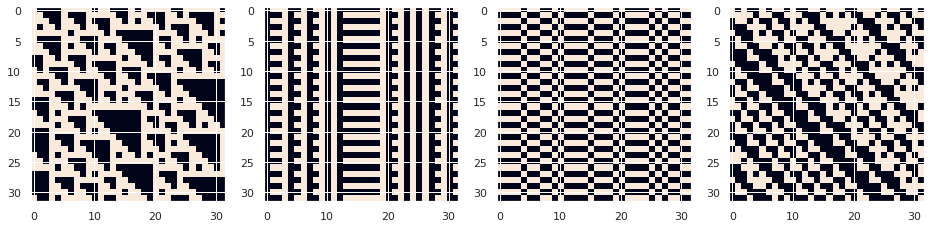

<Figure size 432x288 with 0 Axes>

In [19]:
imagePreview(X_train)

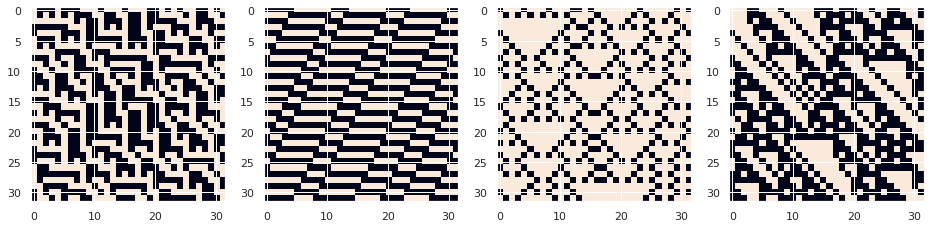

<Figure size 432x288 with 0 Axes>

In [20]:
X_test = getImages(X_test)

imagePreview(X_test)

In [21]:
X_train[0].shape

(32, 32, 1)

## Training

In [22]:
# parameters
kernel = 3
stride = 2

# input
inputs_conv1 = keras.Input(shape=(height, width, 1), name='conv1')

# CNN
conv1 = Conv2D(32, kernel, activation='relu', name='conv2')(inputs_conv1)
pool1 = MaxPooling2D(stride, name='pool1')(conv1)
conv1 = Conv2D(32, kernel, activation='relu',name='conv3')(pool1)

flat = Flatten(name='flt')(conv1)

dense = Dense(64, activation='relu', name='dense')(flat)

# out
output = Dense(4, activation='softmax', name='out')(dense)


model = Model(inputs=inputs_conv1, outputs=output)

model.build((None,height,width,1))

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 conv2 (Conv2D)              (None, 30, 30, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 15, 15, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 13, 13, 32)        9248      
                                                                 
 flt (Flatten)               (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 out (Dense)                 (None, 4)                 260   

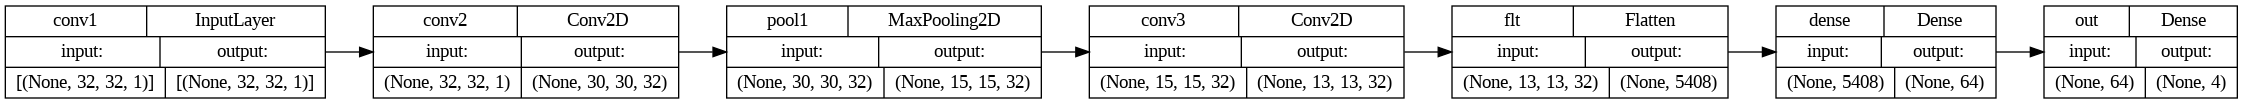

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

In [25]:
# Model
save_dir = '../saved_models/comelli_equiv_V2_best.h5'

# 1e-2
opt = Adam(learning_rate=1e-2, amsgrad=True)
met = tf.keras.metrics.CategoricalAccuracy()

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=[met]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir, 
                            monitor='val_categorical_accuracy', verbose=1, 
                            save_best_only=True, mode='max')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', 
                                      min_delta=0.05, verbose=1, patience=15)

callbacks_list = [checkpoint, es]

hist = model.fit(        
    x = X_train,
    y = y_train,
    validation_data=([X_test], y_test),
    # ep 50, b 12
    epochs=200,
    batch_size=64,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/200
1047/1047 [==============================] - ETA: 0s - loss: 0.9287 - categorical_accuracy: 0.5201
Epoch 1: val_categorical_accuracy improved from -inf to 0.62015, saving model to ./drive/Shareddrives/Memoria/code/best_models/comelli_equiv_V2_best.h5
1047/1047 [==============================] - 18s 7ms/step - loss: 0.9287 - categorical_accuracy: 0.5201 - val_loss: 0.8425 - val_categorical_accuracy: 0.6202
Epoch 2/200
1041/1047 [============================>.] - ETA: 0s - loss: 0.5872 - categorical_accuracy: 0.7559
Epoch 2: val_categorical_accuracy improved from 0.62015 to 0.83558, saving model to ./drive/Shareddrives/Memoria/code/best_models/comelli_equiv_V2_best.h5
1047/1047 [==============================] - 7s 7ms/step - loss: 0.5857 - categorical_accuracy: 0.7567 - val_loss: 0.4929 - val_categorical_accuracy: 0.8356
Epoch 3/200
1043/1047 [============================>.] - ETA: 0s - loss: 0.2620 - categorical_accuracy: 0.9148
Epoch 3: val_categorical_accuracy improved fr

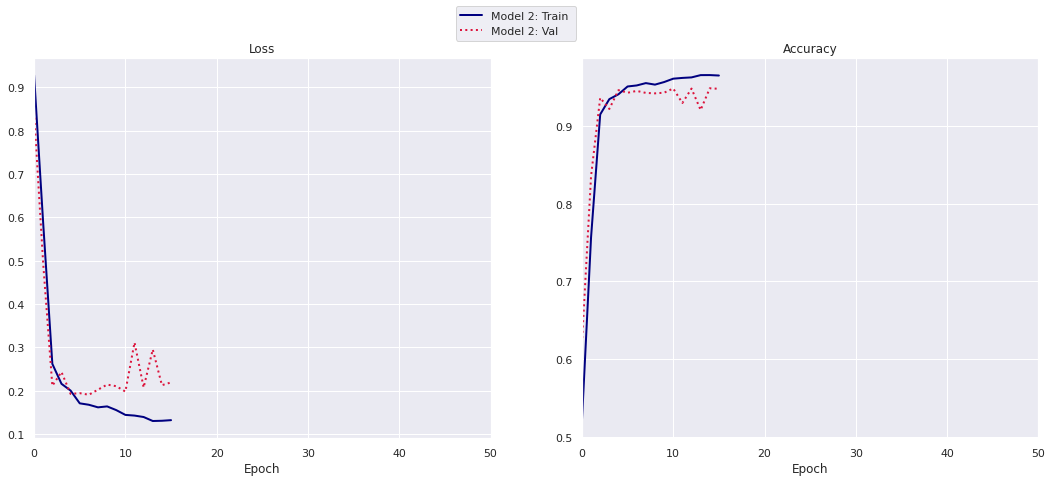

In [26]:
fig = plt.figure(figsize=(18, 7), facecolor='w', edgecolor='k')
gs  = gridspec.GridSpec(nrows=1, ncols=2)
ax = plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1])

colors_list = ["crimson", "orchid", "navy", "aqua"]

num=2
l1 = ax[0].plot(hist.history['loss'], c=colors_list[num] ,label='Model '+str(num)+': Train ', linewidth=2)
ax[0].plot(hist.history['val_loss'], ls='dotted', c=colors_list[0], label='Model '+str(num)+': Val', linewidth=2)

ax[1].plot(hist.history['categorical_accuracy'], c=l1[0].get_color(), linewidth=2)
ax[1].plot(hist.history['val_categorical_accuracy'], ls='dotted', c=colors_list[0], linewidth=2)

# labels
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_xlim([0, 50])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_xlim([0, 50])

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(labels, loc="best", bbox_to_anchor=(0, 1.15))
plt.show()